This notebook shows that how random noise embedder, impulse embedder and square wave embedder works.

In [25]:
from pylab import *
from skimage.color import rgb2gray
from skimage.transform import rescale,resize
from torch.autograd import Variable
import torch, time,os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy


# Set the CUDA flag
cuda_flag = True
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
criterion = torch.nn.MSELoss()
epochs = 4000
lr = 1e-4


sample_N = 512
sample_ds = [1,2,3,4,6,8,11,16]
sigs = 10**np.linspace(-1,-4,50)
embedding_dimension = 10000

Ns = len(sigs)
Nd = len(sample_ds)
N_test = 10
N_repeat = 2

#kk = torch.randint(512,(N_test,))
kk = [158, 329,  47, 344, 257, 410, 426, 199, 426, 295]
#kk = [ 88, 269, 409,  59, 245, 382, 277, 362,  23, 308, 504, 448, 411, 304, 365, 200,  92, 350, 405,  77]

losses_ = np.zeros((Nd,Ns,N_test,N_repeat,epochs))
sr_ = np.zeros((Nd,Ns))
trn_psnr_ = np.zeros((Nd,Ns,N_test,N_repeat,epochs))
tst_psnr_ = np.zeros((Nd,Ns,N_test,N_repeat,epochs))

file_path = 'Final_2one/'

In [11]:
rgb = imread('4.2.07.tiff');im = rgb2gray(rgb);
signal = torch.from_numpy(im).type(torch.FloatTensor)

In [12]:
width = 256

# Here define the MLP
class SLP(nn.Module):
    def __init__(self,input_dim):
        super(SLP, self).__init__()
        self.fco = nn.Linear(input_dim, 1)
    def forward(self, x):
        out = self.fco(x)
        return out
    def name(self):
        return "SLP"

In [13]:
def srank_func(X):
    # Get the SVD
    (u,s,v) = torch.svd(X)
    sr = (s*s).sum()/s[0]/s[0]
    return sr

def psnr_func(x,y):
    diff = x - y
    err = (diff*diff).flatten().mean().log10()
    return -10*err

def impulse_embedding(x, b, s=1e-4):
    emb = (abs(x-b)<s).type(torch.FloatTensor)
    return emb/emb.norm(dim=1).max()

def square_embedding(x, b, f=1):
    emb = (torch.sin(2.*np.pi*f*(x-b))>0).type(torch.FloatTensor)
    return emb/emb.norm(dim=1).max()

def shift_embedding(x, c):
    all_emb = scipy.linalg.circulant(c)
    idx = (x*all_emb.shape[0]).int().squeeze()
    emb = torch.from_numpy(all_emb[idx]).type(torch.FloatTensor)
    return emb/emb.norm(dim=1).max()
    

def norm_func(x):
    # Flatten the data 
    #x = x.flatten(1,3)
    
    # Normalize for gain and bias
    y = x-x.mean(1).unsqueeze(-1)
    y = x/x.norm(dim=1).unsqueeze(-1)    
    return y

In [14]:
all_data = torch.from_numpy(np.linspace(0, 1, sample_N+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)


for i in range(Nd):
    sample_d = sample_ds[i]
    
    for ff in range(Ns):
        sig = sigs[ff]
        
        c = np.exp(-0.5*(np.linspace(0, 1, embedding_dimension+1)[:-1]-0.5)**2/sig**2)
        c = c/np.linalg.norm(c)
        
        train_data = shift_embedding(all_data[::2*sample_d],c)
        test_data = shift_embedding(all_data[sample_d::2*sample_d],c)

        # Calculate the input stable rank
        sr_[i,ff] = srank_func(train_data)


        for j in range(N_test):
            start_time = time.time()


            # Prepare the data
            all_target = signal[kk[j]].reshape(-1,1)
            train_label = all_target[::2*sample_d]
            test_label = all_target[sample_d::2*sample_d]

            xt, yt = train_data.cuda(),train_label.cuda()
            xt, yt = Variable(xt), Variable(yt)

            xts, yts = test_data.cuda(),test_label.cuda()


            for k in range(N_repeat):
                # Initialize classification model to learn
                model = SLP(embedding_dimension).cuda()
                # Set the optimization
                optimizer = optim.Adam(model.parameters(), lr/10**((log10(sig)+1)/3)/2, betas=(0.9, 0.999),weight_decay=1e-8)


                for epoch in range(epochs):
                    model.train()
                    optimizer.zero_grad()

                    out = model(xt)
                    loss = criterion(out, yt)

                    loss.backward()
                    losses_[i,ff,j,k,epoch] = loss.item()
                    optimizer.step()

                    model.eval()
                    trn_psnr_[i,ff,j,k,epoch] = psnr_func(model(xt),yt)
                    tst_psnr_[i,ff,j,k,epoch] = psnr_func(model(xts),yts)


                print("==>>> N: %g, F: %g, train psnr: %g--- , test psnr: %g--- , time: %g seconds ---" 
                        % (i,ff, np.mean(trn_psnr_[i,ff,j,k,-100:]),np.mean(tst_psnr_[i,ff,j,k,-100:]),time.time() - start_time))

==>>> N: 0, F: 0, train psnr: 15.6414--- , test psnr: 15.7944--- , time: 6.4484 seconds ---
==>>> N: 0, F: 1, train psnr: 15.9259--- , test psnr: 16.0813--- , time: 6.50415 seconds ---
==>>> N: 0, F: 2, train psnr: 17.4081--- , test psnr: 17.6786--- , time: 6.48004 seconds ---
==>>> N: 0, F: 3, train psnr: 19.566--- , test psnr: 19.8478--- , time: 6.4896 seconds ---
==>>> N: 0, F: 4, train psnr: 21.8042--- , test psnr: 22.1635--- , time: 6.45566 seconds ---
==>>> N: 0, F: 5, train psnr: 23.1706--- , test psnr: 23.7805--- , time: 6.49629 seconds ---
==>>> N: 0, F: 6, train psnr: 25.867--- , test psnr: 26.3933--- , time: 6.24836 seconds ---
==>>> N: 0, F: 7, train psnr: 28.0411--- , test psnr: 27.8209--- , time: 6.32938 seconds ---
==>>> N: 0, F: 8, train psnr: 30.526--- , test psnr: 28.2153--- , time: 6.21176 seconds ---
==>>> N: 0, F: 9, train psnr: 34.4812--- , test psnr: 27.7903--- , time: 6.39346 seconds ---
==>>> N: 0, F: 10, train psnr: 56.9657--- , test psnr: 27.3973--- , time: 6

/home/jianqiao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


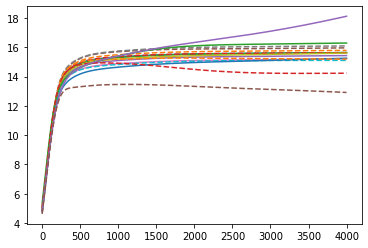

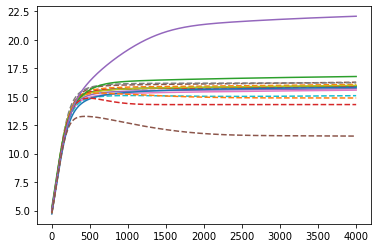

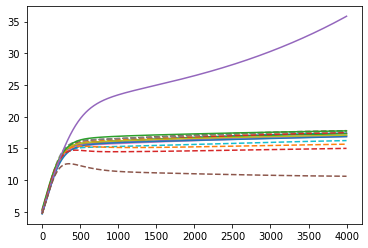

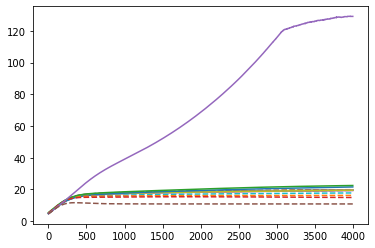

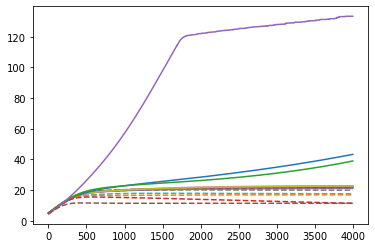

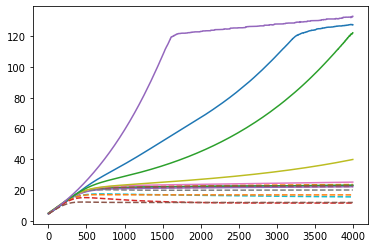

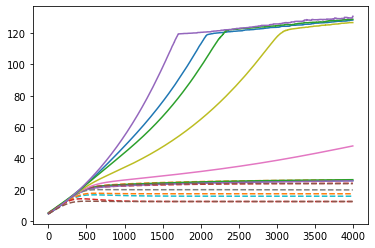

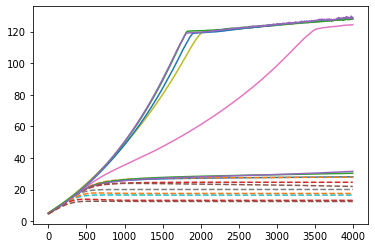

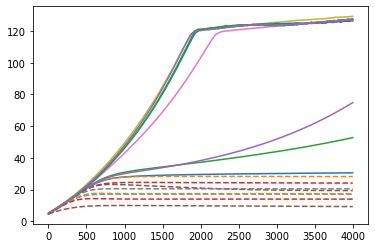

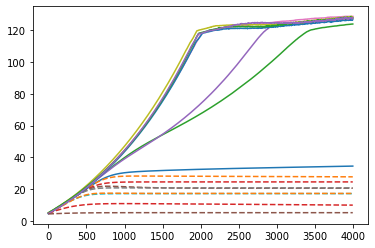

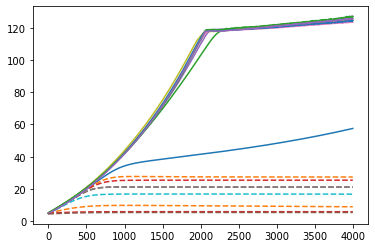

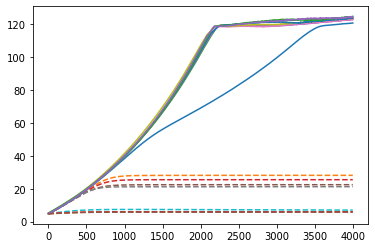

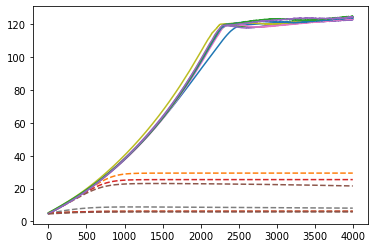

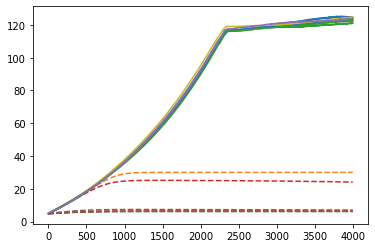

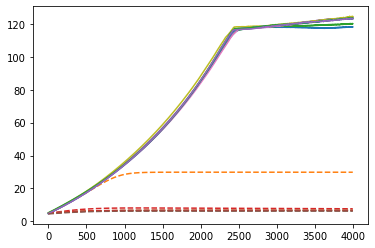

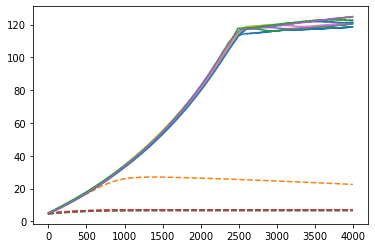

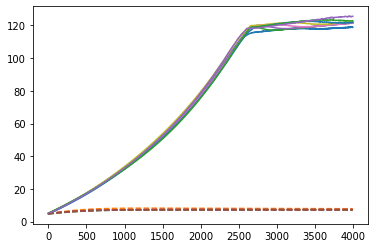

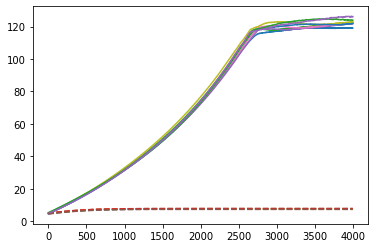

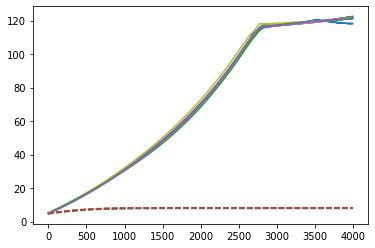

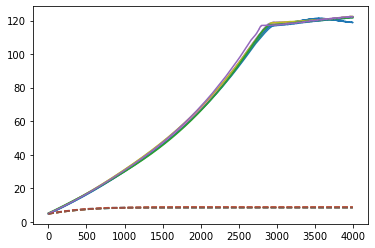

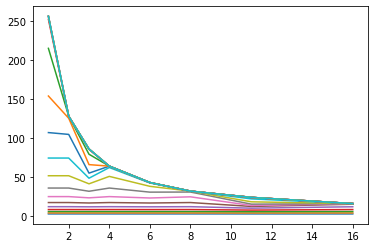

In [15]:
for i in range(Ns):
    figure()
    for j in range(Nd):
        plot(np.mean(trn_psnr_[j,i,:,:],(0,1)))
        plot(np.mean(tst_psnr_[j,i,:,:],(0,1)),'--')

figure()
for i in range(Ns):
    plot(sample_ds,sr_[:,i])

In [7]:
file_name = 'rbf_2'
np.save(file_path+file_name+'_losses',losses_)
np.save(file_path+file_name+'_sr',sr_)
np.save(file_path+file_name+'_trn',trn_psnr_)
np.save(file_path+file_name+'_tst',tst_psnr_)

In [21]:
def rbf_embedding(x,dic,sig):
    rbfemb = (-0.5*(x-dic)**2/sig**2).exp()
    rbfemb = rbfemb/rbfemb.norm(dim=1).max()
    return rbfemb

In [ ]:
all_data = torch.from_numpy(np.linspace(0, 1, sample_N+1)[:-1].reshape(-1,1)).type(torch.FloatTensor)
dic = torch.from_numpy(np.linspace(0, 1, embedding_dimension+1)[:-1].reshape(1,-1)).type(torch.FloatTensor)

for i in range(Nd):
    sample_d = sample_ds[i]
    
    for ff in range(Ns):

        train_data = rbf_embedding(all_data[::2*sample_d],dic,sigs[ff])
        test_data = rbf_embedding(all_data[sample_d::2*sample_d],dic,sigs[ff])

        # Calculate the input stable rank
        sr_[i,ff] = srank_func(train_data)


        for j in range(N_test):
            start_time = time.time()


            # Prepare the data
            all_target = signal[kk[j]].reshape(-1,1)
            train_label = all_target[::2*sample_d]
            test_label = all_target[sample_d::2*sample_d]

            xt, yt = train_data.cuda(),train_label.cuda()
            xt, yt = Variable(xt), Variable(yt)

            xts, yts = test_data.cuda(),test_label.cuda()


            for k in range(N_repeat):
                # Initialize classification model to learn
                model = SLP(embedding_dimension).cuda()
                # Set the optimization
                optimizer = optim.Adam(model.parameters(), lr/10**((log10(sig)+1)/3)/2, betas=(0.9, 0.999),weight_decay=1e-8)


                for epoch in range(epochs):
                    model.train()
                    optimizer.zero_grad()

                    out = model(xt)
                    loss = criterion(out, yt)

                    loss.backward()
                    losses_[i,ff,j,k,epoch] = loss.item()
                    optimizer.step()

                    model.eval()
                    trn_psnr_[i,ff,j,k,epoch] = psnr_func(model(xt),yt)
                    tst_psnr_[i,ff,j,k,epoch] = psnr_func(model(xts),yts)


                print("==>>> N: %g, F: %g, train psnr: %g--- , test psnr: %g--- , time: %g seconds ---" 
                        % (i,ff, np.mean(trn_psnr_[i,ff,j,k,-100:]),np.mean(tst_psnr_[i,ff,j,k,-100:]),time.time() - start_time))

==>>> N: 0, F: 0, train psnr: 15.7028--- , test psnr: 15.8223--- , time: 6.06751 seconds ---
==>>> N: 0, F: 0, train psnr: 15.7004--- , test psnr: 15.8192--- , time: 12.286 seconds ---
==>>> N: 0, F: 0, train psnr: 18.4336--- , test psnr: 18.2083--- , time: 6.3075 seconds ---
==>>> N: 0, F: 0, train psnr: 18.4324--- , test psnr: 18.2072--- , time: 12.708 seconds ---
==>>> N: 0, F: 0, train psnr: 18.3836--- , test psnr: 18.8385--- , time: 6.14401 seconds ---
==>>> N: 0, F: 0, train psnr: 18.3837--- , test psnr: 18.8388--- , time: 12.3173 seconds ---
==>>> N: 0, F: 0, train psnr: 19.3626--- , test psnr: 19.1487--- , time: 6.17803 seconds ---
==>>> N: 0, F: 0, train psnr: 19.3636--- , test psnr: 19.1498--- , time: 12.3833 seconds ---
==>>> N: 0, F: 0, train psnr: 15.7212--- , test psnr: 15.6282--- , time: 6.24609 seconds ---
==>>> N: 0, F: 0, train psnr: 15.7201--- , test psnr: 15.6272--- , time: 12.4502 seconds ---
==>>> N: 0, F: 0, train psnr: 19.8922--- , test psnr: 20.3177--- , time: 

In [ ]:
for i in range(Ns):
    figure()
    for j in range(Nd):
        plot(np.mean(trn_psnr_[j,i,:,:],(0,1)))
        plot(np.mean(tst_psnr_[j,i,:,:],(0,1)),'--')

figure()
for i in range(Ns):
    plot(sample_ds,sr_[:,i])

In [ ]:
file_name = 'rbf_old2'
np.save(file_path+file_name+'_losses',losses_)
np.save(file_path+file_name+'_sr',sr_)
np.save(file_path+file_name+'_trn',trn_psnr_)
np.save(file_path+file_name+'_tst',tst_psnr_)